In [59]:
print('Namaste!')

Namaste!


Rules:

In [60]:
rem_warnings = True

Investment parameters (weeks):

In [61]:
horizon_max = 156  # 3Y
scale = 56  # 1Y

Statistical parameters:

In [62]:
p = 0.95  # quantile

Drop warnings:

In [63]:
import warnings
if rem_warnings is True:
    warnings.filterwarnings('ignore')

Libraries:

In [64]:
import pandas as pd
import numpy as np
import scipy as sc
import math
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm_notebook as tqdm
from tqdm.auto import tqdm as progress
import statsmodels.formula.api as sm

Read data:

In [65]:
df_sap = pd.read_csv('data/sap.csv', delimiter=',', names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
df_gold = pd.read_csv('data/gold.csv', delimiter=',', names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])

Drop columns:

In [66]:
df_sap = df_sap.dropna(how='any', axis=0)[['date', 'close']].rename(columns={'close': 'close_sap'})
df_gold = df_gold.dropna(how='any', axis=0)[['date', 'close']].rename(columns={'close': 'close_gold'})

Dates:

In [67]:
df_source = pd.merge(df_sap, df_gold, on='date').dropna(how='any', axis=0)
df_source = df_source.tail(len(df_source) - horizon_max)

print('Start date:', str(list(df_source['date'])[0]))
print('End date:', str(list(df_source['date'])[-1]))

Start date: 2001.09.02
End date: 2019.10.20


Create empty frame:

In [68]:
col_names = ['horizon', 'return_sap', 'return_gold', 'var_sap', 'var_gold', 'return_sap(a)', 'return_gold(a)']
df_match = pd.DataFrame(columns=col_names)

Record series:

In [69]:
for h in tqdm(range(1,157)):
    df = pd.merge(df_sap, df_gold, on='date').dropna(how='any', axis=0)
    
    df[['return_sap', 'return_gold']] = df[['close_sap', 'close_gold']].apply(np.log)
    df[['return_sap', 'return_gold']] = 100*df[['return_sap', 'return_gold']].diff(periods=h)
    
    df = df.tail(len(df) - horizon_max)
    
    return_sap_m = df['return_sap'].median()
    return_gold_m = df['return_gold'].median()
        
    var_sap = df[df['return_sap'] < 0]['return_sap'].abs().quantile(p)
    var_gold = df[df['return_gold'] < 0]['return_gold'].abs().quantile(p)
    
    return_sap_ann = return_sap_m/(h/scale)
    return_gold_ann = return_gold_m/(h/scale)

    match_list = []
    match_list.extend([h, return_sap_m, return_gold_m, var_sap, var_gold, return_sap_ann, return_gold_ann])
    df_match.loc[len(df_match)] = match_list    

Make plot for VaR:

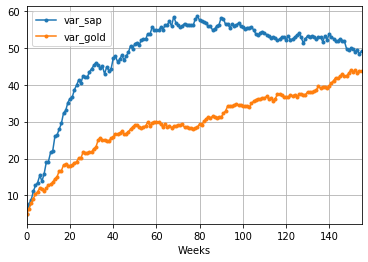

In [70]:
df_match[['var_sap', 'var_gold']].plot(style='-o', markersize=3, grid=True)
plt.xlabel('Weeks')
plt.show()

Define return vs risk:

In [71]:
df_match['return_risk_sap'] = df_match['return_sap']/df_match['var_sap']
df_match['return_risk_gold'] = df_match['return_gold']/df_match['var_gold']

Make plot for return vs risk:

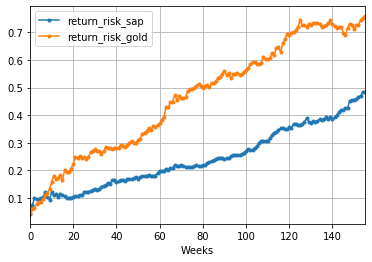

In [72]:
df_match[['return_risk_sap', 'return_risk_gold']].plot(style='-o', markersize=3, grid=True)
plt.xlabel('Weeks')
plt.show()

Annual returns with scale effect:

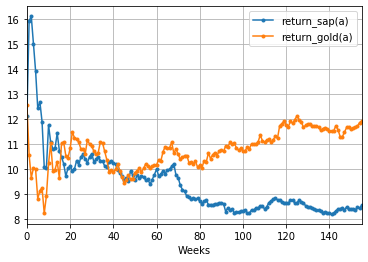

In [73]:
df_match[['return_sap(a)', 'return_gold(a)']].plot(style='-o', markersize=3, grid=True)
plt.xlabel('Weeks')
plt.show()

Annual returns without scale effect:

In [74]:
cum_sap = 100*(list(df_source['close_sap'])[-1]-list(df_source['close_sap'])[0])/list(df_source['close_sap'])[0]
cum_gold = 100*(list(df_source['close_gold'])[-1]-list(df_source['close_gold'])[0])/list(df_source['close_gold'])[0]

ann_sap = int(round(cum_sap/(len(df_source)/scale)))
ann_gold = int(round(cum_gold/(len(df_source)/scale)))

print('Annual return SP500:', ann_sap, '%')
print('Annual return Gold:', ann_gold, '%')

Annual return SP500: 11 %
Annual return Gold: 27 %


Write to xlsx:

In [75]:
writer = pd.ExcelWriter('data/matched.xlsx', engine='xlsxwriter')
df_match.to_excel(writer, sheet_name='market_matched', index=False)
writer.save()